## Poisson Equation Animation

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from Poissoneq_class import Poisson_lattice
from matplotlib.colors import SymLogNorm
from scipy import stats

In [26]:
# fixed parameters
n = 50
tol = 1e-7

# source terms
#source = Poisson_lattice.set_delta(n) # delta source (+ve), gauss law
#source = Poisson_lattice.set_dipole(n) # dipole source, gauss law
source = Poisson_lattice.set_wire_j(n) # wire config on xy plane, ampere's law

lattice = np.zeros((n,n)) # depends on e (n,n,n) or b (n,n) system

system = Poisson_lattice(lattice, source, tol)

In [20]:
# solve Gauss Law via Jacobi
system.phi_jacobi_iterate()

Jacobi solver took 7318 iterations.


array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.83438036e-07, 9.66876075e-07, ...,
         1.02431134e-06, 5.12320133e-07, 0.00000000e+00],
        [0.00000000e+00, 

In [21]:
print(system.lattice[n//2,n//2,n//2])
print(system.source[n//2,n//2,n//2])

0.2498891854292108
1.0


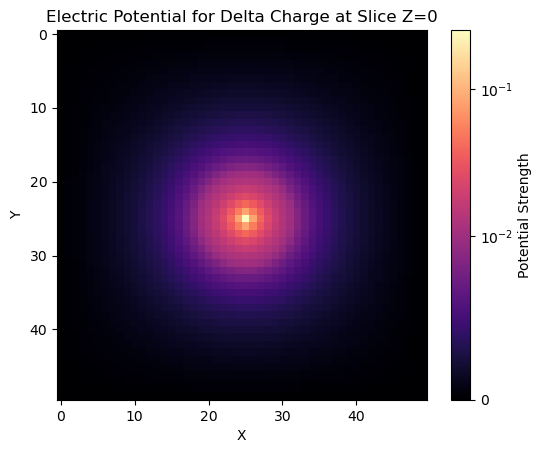

In [22]:
# visualise
im=plt.imshow(system.lattice[:,:,n//2], cmap='magma', norm=SymLogNorm(linthresh=0.01))
cbar = plt.colorbar(im)
cbar.set_label('Potential Strength')
plt.title('Electric Potential for Delta Charge at Slice Z=0')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

/var/folders/r_/tmxbzfd12vn6b66nr7j6qmlr0000gn/T/ipykernel_27545/3846744025.py:3: RuntimeWarning: invalid value encountered in divide
  Ex_norm, Ey_norm = Ex/E_norm, Ey/E_norm


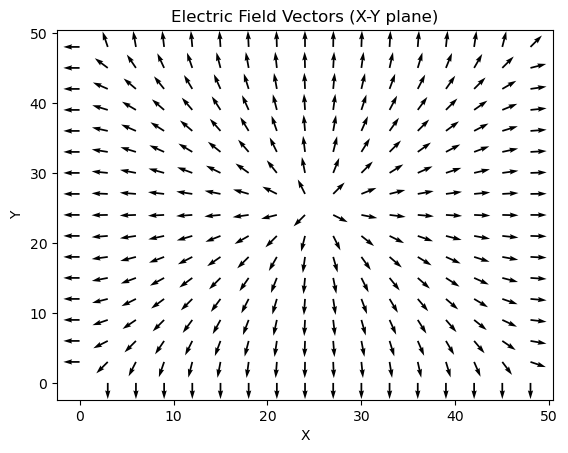

In [23]:
# compute E field
Ex, Ey, Ez, E_norm = system.return_E()
Ex_norm, Ey_norm = Ex/E_norm, Ey/E_norm

# use center_y to see vectors in the x-y plane
center_z = n // 2 

# create a figure
plt.figure()

# create meshgrid for x-y plane
x = np.arange(0, n)
y = np.arange(0, n)
X, Y = np.meshgrid(x, y, indexing='ij')

# plot Ex and Ey components
skip = 3
plt.quiver(Y[::skip, ::skip], X[::skip, ::skip],
           Ey_norm[::skip, ::skip, center_z], Ex_norm[::skip, ::skip, center_z])

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Electric Field Vectors (X-Y plane)')
plt.show()

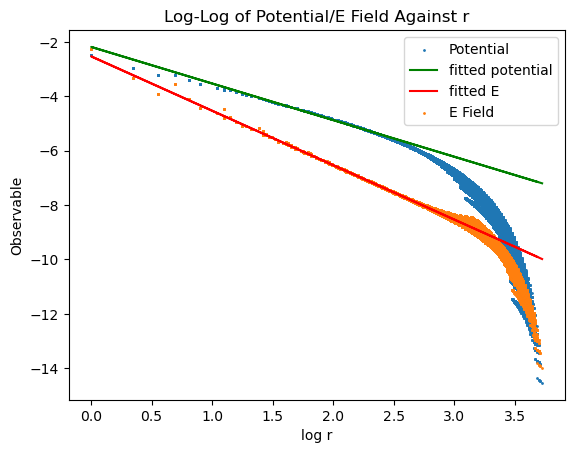

LinregressResult(slope=np.float64(-1.3457241582848423), intercept=np.float64(-2.1838686241623897), rvalue=np.float64(-0.9967151971190937), pvalue=np.float64(0.0), stderr=np.float64(0.0012610912903204623), intercept_stderr=np.float64(0.002761862282536874))
LinregressResult(slope=np.float64(-1.9997349727517533), intercept=np.float64(-2.531805633406374), rvalue=np.float64(-0.9982691949700789), pvalue=np.float64(0.0), stderr=np.float64(0.000640054509030676), intercept_stderr=np.float64(0.0017197411038372774))


In [24]:
# visualise potential strength wrt radial distance (only for delta charge!)
radial_distance_3d = system.return_radial_cube()

r_flatten = radial_distance_3d.flatten()
potential_flatten = system.lattice.flatten()
E_flatten = E_norm.flatten()

bool_mask = (r_flatten != 0) & (potential_flatten != 0) & (E_flatten != 0) # only taking non singular values

log_r = np.log(r_flatten[bool_mask])
log_potential = np.log(potential_flatten[bool_mask])
log_E = np.log(E_flatten[bool_mask])

indices_r_potential = np.where(log_r<2.5) # choosing fitting data
indices_r_E = np.where(log_r<3)            # choosing fitting data
training_r_potential = log_r[indices_r_potential]
training_potential = log_potential[indices_r_potential]
training_r_E = log_r[indices_r_E]
training_E = log_E[indices_r_E]

#linear regression with fitting data
res_potential = stats.linregress(training_r_potential, training_potential)
res_E = stats.linregress(training_r_E, training_E)

plt.scatter(log_r, log_potential, s=1, label='Potential')
plt.plot(log_r, res_potential.intercept + res_potential.slope*log_r, label='fitted potential', color='g')
plt.plot(log_r, res_E.intercept + res_E.slope*log_r, label='fitted E', color='r')
plt.scatter(log_r, log_E, s=1, label='E Field')
plt.title('Log-Log of Potential/E Field Against r')
plt.legend(loc='best')
plt.xlabel('log r')
plt.ylabel('Observable')
plt.show()

print(res_potential)
print(res_E)

In [25]:
# save numpy arrays
data = {"potential": system.lattice,
        "E_field": system.return_E(),
        "r": radial_distance_3d
}

np.save("gauss_law_jacobi",data)

In [8]:
# solve Gauss Law via SOR
_, iter_count = system.phi_SOR_iterate(omega=1.9)
print(f'Iter is: {iter_count}')

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [17]:
# solve Gauss Law via Gauss Seidel
system.phi_gauss_seidel_iterate()

Gauss Seidel solver took 1590 iterations.


array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.81011331e-07, 9.62042582e-07, ...,
         1.01990422e-06, 5.10116573e-07, 0.00000000e+00],
        [0.00000000e+00, 

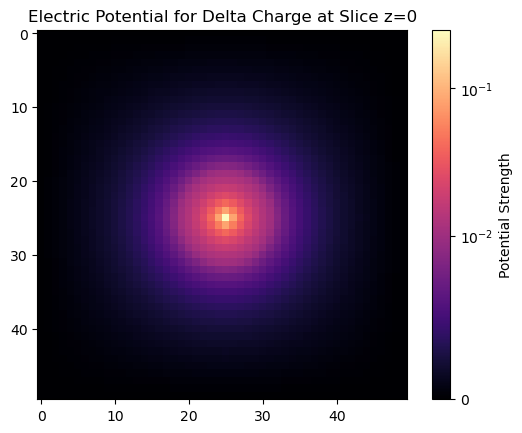

In [15]:
# visualise
im=plt.imshow(system.lattice[:,:,n//2], cmap='magma', norm=SymLogNorm(linthresh=0.1))
cbar = plt.colorbar(im)
cbar.set_label('Potential Strength')
plt.title('Electric Potential for Delta Charge at Slice z=0')
plt.show()

In [27]:
# solve Ampere's Law via Jacobi
system.A_jacobi_iterate()

Jacobi solver took 7398 iterations.


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00043154, 0.00086309, ..., 0.00090902, 0.00045461,
        0.        ],
       [0.        , 0.00086309, 0.00172622, ..., 0.0018185 , 0.00090943,
        0.        ],
       ...,
       [0.        , 0.00090902, 0.0018185 , ..., 0.00192118, 0.00096056,
        0.        ],
       [0.        , 0.00045461, 0.00090943, ..., 0.00096056, 0.00048028,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(50, 50))

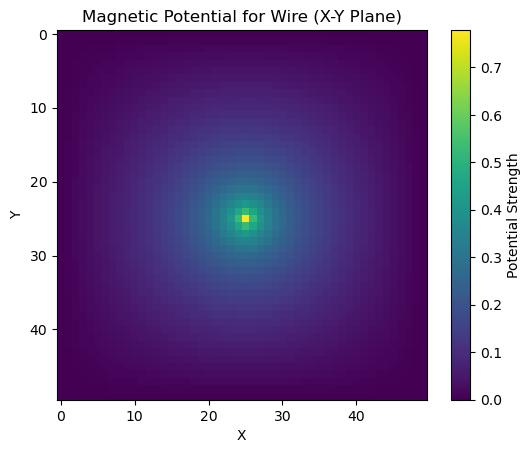

In [28]:
# visualise
im=plt.imshow(system.lattice[:,:])
cbar = plt.colorbar(im)
cbar.set_label('Potential Strength')
plt.title('Magnetic Potential for Wire (X-Y Plane)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

/var/folders/r_/tmxbzfd12vn6b66nr7j6qmlr0000gn/T/ipykernel_27545/2129711735.py:3: RuntimeWarning: invalid value encountered in divide
  Bx_norm, By_norm = Bx/B_norm, By/B_norm


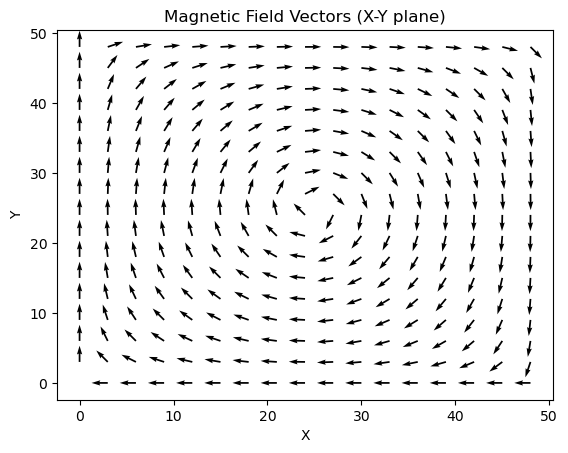

In [29]:
# compute B field
Bx, By, B_norm = system.return_B()
Bx_norm, By_norm = Bx/B_norm, By/B_norm

# create a figure
plt.figure()

# create meshgrid for x-y plane
x = np.arange(0, n)
y = np.arange(0, n)
X, Y = np.meshgrid(x, y, indexing='ij')

# plot Ex and Ey components
skip = 3
plt.quiver(Y[::skip, ::skip], X[::skip, ::skip],
           By_norm[::skip, ::skip], Bx_norm[::skip, ::skip])

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Magnetic Field Vectors (X-Y plane)')
plt.show()

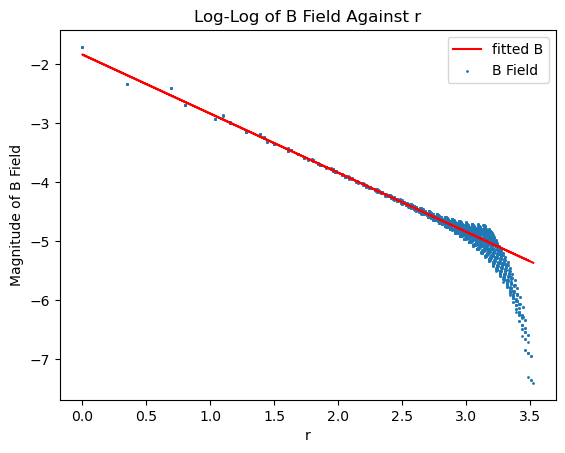

LinregressResult(slope=np.float64(-1.0017374250598008), intercept=np.float64(-1.8337969490912855), rvalue=np.float64(-0.9952423532400353), pvalue=np.float64(0.0), stderr=np.float64(0.002760509823615609), intercept_stderr=np.float64(0.0070375817285341985))


In [30]:
# visualise potential strength wrt radial distance (only for delta charge!)
radial_distance_2d = system.return_radial_square()

r_flatten = radial_distance_2d.flatten()
potential_flatten = system.lattice.flatten()
B_flatten = B_norm.flatten()

bool_mask = (r_flatten != 0) & (potential_flatten != 0) & (B_flatten != 0) # only taking non singular values

log_r = np.log(r_flatten[bool_mask])
#log_potential = np.log(potential_flatten[bool_mask])
log_B = np.log(B_flatten[bool_mask])

#indices_r_potential = np.where(log_r<2.5) # choosing fitting data
indices_r_B = np.where(log_r<3)            # choosing fitting data
#training_r_potential = log_r[indices_r_potential]
#training_potential = log_potential[indices_r_potential]
training_r_B = log_r[indices_r_B]
training_B = log_B[indices_r_B]

# linear regression with fitting data
#res_potential = stats.linregress(training_r_potential, training_potential) 
res_B = stats.linregress(training_r_B, training_B)

#plt.scatter(log_r, log_potential, s=1, label='Potential')
#plt.plot(log_r, res_potential.intercept + res_potential.slope*log_r, label='fitted potential', color='g')
plt.plot(log_r, res_B.intercept + res_B.slope*log_r, label='fitted B', color='r')
plt.scatter(log_r, log_B, s=1, label='B Field')
plt.title('Log-Log of B Field Against r')
plt.legend(loc='best')
plt.xlabel('r')
plt.ylabel('Magnitude of B Field')
plt.show()

#print(res_potential)
print(res_B)

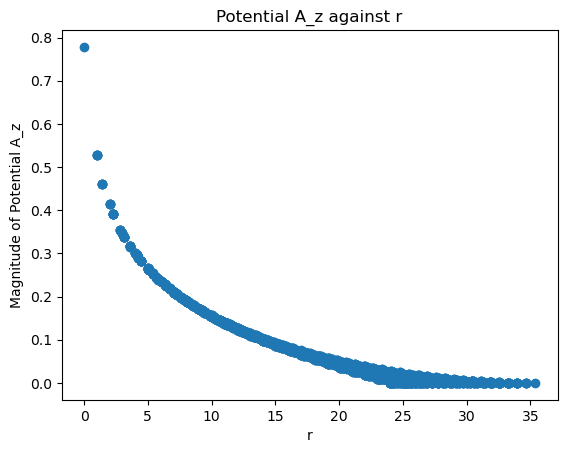

In [31]:
plt.scatter(r_flatten, potential_flatten)
plt.xlabel('r')
plt.ylabel('Magnitude of Potential A_z')
plt.title('Potential A_z against r')
plt.show()

In [32]:
# save numpy arrays
data = {"potential": system.lattice,
        "E_field": system.return_B(),
        "r": radial_distance_2d
}

np.save("straight_wire_jacobi",data)